# EUREC4A platforms and the meso-scale organization
This notebook illustrates how the Level3 data can be used to put the wide-range of research platforms into context of the meso-scale organization. Depending on their track and location, the meso-scale organization they were situated in varied.

The timeseries of RV Meteor, Barbados Cloud Observatory and RV Atalante are shown below and can be easily adapted for other platforms.

Note: On mistral, this script needs to be executed on resources with internet access.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import dates
import datetime as dt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# Workflow as given in l3 output
workflow = 'IR'
mode = 'daily'

# Level3 filename (input)
level3_file = '../processed_data/EUREC4A_ManualClassifications_l3_{workflow}_{mode}.zarr'.format(workflow=workflow, mode=mode)

# Figure directory (output)
outdir = '../figures/'

In [3]:
ds = xr.open_zarr(level3_file)

In [4]:
color_dict = {'Fish':'#2281BB',
              'Flowers': '#93D2E2',
              'Gravel': '#3EAE47',
              'Sugar': '#A1D791',
              'Unclassified': 'lightgrey'
             }

## Classifications at stationary position

In [5]:
if mode == 'daily':
    data = ds.freq.sel(latitude=13.1626389, longitude=-059.4287500, method='nearest')
    data2 = data
elif mode =='instant':
    data=(ds.freq.sel(latitude=13.1626389, longitude=-059.4287500, method='nearest') * ds.nb_users).groupby(ds.date.dt.date).mean().compute()
    data2 = data/ds.nb_users.groupby(ds.date.dt.date).mean().compute()

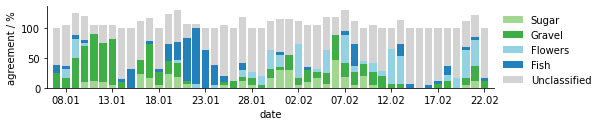

In [6]:
frequency = np.zeros((len(data2.date)))

fig, ax = plt.subplots(figsize=(8,1.5))

for p in ['Sugar', 'Gravel', 'Flowers', 'Fish', 'Unclassified']:
    data_ = data2.sel(pattern=p).values *100
    data_[np.isnan(data_)] = 0
    ax.bar(dates.date2num(data.date), data_, label=p, bottom=frequency, color=color_dict[p])
    frequency += data_
    hfmt = dates.DateFormatter('%d.%m')
    ax.xaxis.set_major_locator(dates.DayLocator(interval=5))
    ax.xaxis.set_major_formatter(hfmt)
plt.legend(frameon=False, bbox_to_anchor=(1,1))
plt.xlabel('date')
plt.ylabel('agreement / %')
plt.xlim(dt.datetime(2020,1,6), dt.datetime(2020,2,23))
sns.despine()
plt.savefig(outdir+'ManualClassification_BCO_{}_{}.pdf'.format(workflow,mode),bbox_inches='tight')

## Classifications along trajectory

In [7]:
#!pip install -e git://github.com/eurec4a/pyeurec4a.git@v0.0.3#egg=eurec4a
import sys
sys.path.append("./src/eurec4a")
import eurec4a
import ipfsspec
cat = eurec4a.get_intake_catalog(use_ipfs=True)

In [8]:
if mode == 'daily':
    ds_classifications_daily = ds.freq
elif mode =='instant':
    ds_classifications_daily = (ds.freq * ds.nb_users).groupby(ds.date.dt.date).mean() / ds.nb_users.groupby(ds.date.dt.date).mean()

### Meteor

In [9]:
trajectory = cat.Meteor.track.to_dask()
trajectory_daily = trajectory.resample(time='1D').mean() # Attention, only works as long as the equator and 0 meridian are not crossed

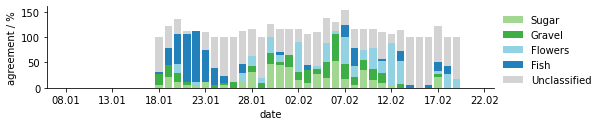

In [10]:
frequency = np.zeros((len(ds.date)))

fig, ax = plt.subplots(figsize=(8,1.5))

for d, date in enumerate(trajectory_daily.time):
    frequency = 0
    lat = trajectory_daily.lat.sel(time=date)
    lon = trajectory_daily.lon.sel(time=date)
    if mode == 'daily':
        date_to_sel = date
    elif mode =='instant':
        date_to_sel = date.dt.date
    for p in ['Sugar', 'Gravel', 'Flowers', 'Fish', 'Unclassified']:
        try:
            data = ds_classifications_daily.sel(latitude=lat, longitude=lon, method='nearest').sel(date=date_to_sel, pattern=p).values *100
        except KeyError:
            print('No data found for date {}'.format(date))
            break
        if np.isnan(data):
            data = 0
        ax.bar(dates.date2num(date), data, label=p, bottom=frequency, color=color_dict[p])
        hfmt = dates.DateFormatter('%d.%m')
        ax.xaxis.set_major_locator(dates.DayLocator(interval=5))
        ax.xaxis.set_major_formatter(hfmt)
        frequency += data
    if d == 0:
        plt.legend(frameon=False, bbox_to_anchor=(1,1))
plt.xlabel('date')
plt.ylabel('agreement / %')
plt.xlim(dt.datetime(2020,1,6), dt.datetime(2020,2,23))
sns.despine()
plt.savefig(outdir+'ManualClassification_Meteor_{}_{}.pdf'.format(workflow, mode),bbox_inches='tight')

## Atalante

In [11]:
trajectory = cat.Atalante.track.to_dask()
trajectory_daily = trajectory.resample(time='1D').mean() # Attention, only works as long as the equator and 0 meridian are not crossed

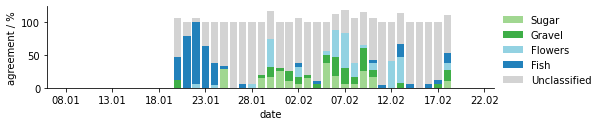

In [12]:
frequency = np.zeros((len(ds.date)))

fig, ax = plt.subplots(figsize=(8,1.5))

for d, date in enumerate(trajectory_daily.time):
    frequency = 0
    lat = trajectory_daily.lat.sel(time=date)
    lon = trajectory_daily.lon.sel(time=date)
    if mode == 'daily':
        date_to_sel = date
    elif mode =='instant':
        date_to_sel = date.dt.date
    for p in ['Sugar', 'Gravel', 'Flowers', 'Fish', 'Unclassified']:
        try:
            data = ds_classifications_daily.sel(latitude=lat, longitude=lon, method='nearest').sel(date=date_to_sel, pattern=p).values *100
        except KeyError:
            print('No data found for date {}'.format(date))
            break
        if np.isnan(data):
            data = 0
        ax.bar(dates.date2num(date), data, label=p, bottom=frequency, color=color_dict[p])
        hfmt = dates.DateFormatter('%d.%m')
        ax.xaxis.set_major_locator(dates.DayLocator(interval=5))
        ax.xaxis.set_major_formatter(hfmt)
        frequency += data
    if d == 0:
        plt.legend(frameon=False, bbox_to_anchor=(1,1))
plt.xlabel('date')
plt.ylabel('agreement / %')
plt.xlim(dt.datetime(2020,1,6), dt.datetime(2020,2,23))
sns.despine()
plt.savefig(outdir+'ManualClassification_Atalante_{}_{}.pdf'.format(workflow, mode),bbox_inches='tight')